# Model Training

## Required Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, time
import os
import joblib
%matplotlib inline

# Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import accuracy_score, jaccard_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay


## Import Dataset

In [2]:
df = pd.read_csv("data\data_cleaned.csv")

In [3]:
df.head(3)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,6,2010-06-04,Falcon 9,8191.07911,LEO,CCSFS SLC 40,0,1,False,False,False,No Pad,1.0,0,B0003,-80.577366,28.561857
1,8,2012-05-22,Falcon 9,525.00000,LEO,CCSFS SLC 40,0,1,False,False,False,No Pad,1.0,0,B0005,-80.577366,28.561857
2,10,2013-03-01,Falcon 9,677.00000,ISS,CCSFS SLC 40,0,1,False,False,False,No Pad,1.0,0,B0007,-80.577366,28.561857


In [4]:
df.shape

(168, 17)

## Feature Engineering

### Preparing Date

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek

### Preparing Indepnedent (X) and Dependent (Y) Features

In [6]:
X = df.drop(['Outcome', 'Date'], axis= 1)

target_column_name = 'Outcome'
y = df[target_column_name]

In [7]:
X.shape

(168, 18)

### Pipeline

In [8]:
num_columns = ['FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount', 'Longitude', 'Latitude', 'Year', 'Month', 'DayOfWeek']
cat_columns = ['BoosterVersion', 'Orbit', 'LaunchSite', 'LandingPad', 'Serial']
bool_columns = ['GridFins', 'Reused', 'Legs']

In [9]:
num_pipeline = Pipeline(
    steps= [
        ('scaler', StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps= [
       ('one_hot_encoder', OneHotEncoder(handle_unknown= 'ignore')) 
    ]
)

preprocessor = ColumnTransformer(
    transformers= [
        ('num_preprocess', num_pipeline, num_columns),
        ('cat_preprocess', cat_pipeline, cat_columns),
        ('bool_preprocess', 'passthrough', bool_columns)
    ]
)

## Train Test Split

In [10]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= .2, random_state= 42)

## Evaluation Matrix

In [11]:
def evaluate_model(true, predicted, predicted_proba= None):
    acc = accuracy_score(true, predicted)
    jac = jaccard_score(true, predicted)
    prec = precision_score(true, predicted, average='weighted', zero_division=0)
    rec = recall_score(true, predicted, average='weighted')
    f1 = f1_score(true, predicted, average='weighted')

    metrics = {
        'Accuracy': acc,
        'Jaccard': jac,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

    if predicted_proba is not None and len(np.unique(true)) == 2:
        auc = roc_auc_score(true, predicted_proba[:, 1])
        metrics['ROC AUC'] = auc

    return metrics


## Models and Hyperparameters

In [12]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbose=0),
    'CatBoost': CatBoostClassifier(verbose=0)
}

params = {
    'Logistic Regression': {
        'C': np.logspace(-4, 4, 9),
        'solver': ['liblinear', 'lbfgs']
    },
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 8, 10, 12, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.5, 1]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.85, 1.0],
        'max_depth': [3, 5, 8]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 1]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.5]
    },
    'CatBoost': {
        'iterations': [100, 200, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'depth': [3, 5, 7],
        'l2_leaf_reg': [1, 3, 5, 9]
    }
}

## GridSearchCV

In [13]:
tic = time.time()
report = []
best_model = None
best_score = - np.inf

for model_name, model in models.items():
    full_pipeline = Pipeline(
        steps= [
            ('preprocessor', preprocessor),
            ('classifier', model)
        ]
    )

    param_grid = {f"classifier__{k}": v for k, v in params[model_name].items()}

    grid = GridSearchCV(
        estimator= full_pipeline,
        param_grid= param_grid,
        cv= 5,
        scoring= 'accuracy',
        n_jobs= -1,
        error_score= 'raise'
    )

    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_param = grid.best_params_

    y_pred_train = best_estimator.predict(X_train)
    y_pred_test = best_estimator.predict(X_test)
    y_proba_test = best_estimator.predict_proba(X_test) if hasattr(best_estimator, 'predict_proba') else None

    metrics_train = evaluate_model(y_train, y_pred_train)
    metrics_test = evaluate_model(y_test, y_pred_test, y_proba_test)

    report.append({
        'Model': model_name,
        'Best Params': best_param,
        'Train Accuracy': metrics_train['Accuracy'],
        'Test Accuracy': metrics_test['Accuracy'],
        'Test Jaccard': metrics_test['Jaccard'],
        'Test Precision': metrics_test['Precision'],
        'Test Recall': metrics_test['Recall'],
        'Test F1': metrics_test['F1 Score'],
        'Test ROC AUC': metrics_test.get('ROC AUC', None)
    })

    if metrics_test['Accuracy'] > best_score:
        best_model = best_estimator
        best_score = metrics_test['Accuracy']

toc = time.time()
training_time = toc - tic
print(f'Training Time: {training_time / 60} minutes')

c:\Users\HP\Documents\Projects\Landing_Prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:38:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Time: 19.807101770242056 minutes


In [14]:
report_df = pd.DataFrame(report).sort_values(by=['Test Accuracy'], ascending=False)
report_df

,Model,Best Params,Train Accuracy,Test Accuracy,Test Jaccard,Test Precision,Test Recall,Test F1,Test ROC AUC
8,CatBoost,"{'classifier__depth': 3, 'classifier__iteratio...",1.000000,0.852941,0.814815,0.859314,0.852941,0.855311,0.915556
6,SVM,"{'classifier__C': 100, 'classifier__gamma': 'a...",1.000000,0.852941,0.827586,0.850840,0.852941,0.842397,0.933333
0,Logistic Regression,"{'classifier__C': 1.0, 'classifier__solver': '...",0.962687,0.823529,0.793103,0.815437,0.823529,0.815894,0.928889
1,Decision Tree,"{'classifier__criterion': 'gini', 'classifier_...",0.955224,0.823529,0.800000,0.820284,0.823529,0.804855,0.744444
4,AdaBoost,"{'classifier__learning_rate': 0.1, 'classifier...",0.947761,0.823529,0.793103,0.815437,0.823529,0.815894,0.917778
5,Gradient Boosting,"{'classifier__learning_rate': 0.01, 'classifie...",0.977612,0.823529,0.800000,0.820284,0.823529,0.804855,0.866667
7,XGBoost,"{'classifier__colsample_bytree': 0.8, 'classif...",1.000000,0.823529,0.785714,0.823529,0.823529,0.823529,0.924444
3,Random Forest,"{'classifier__max_depth': 5, 'classifier__max_...",0.970149,0.794118,0.758621,0.787613,0.794118,0.790081,0.893333
2,KNN,"{'classifier__metric': 'manhattan', 'classifie...",1.000000,0.764706,0.741935,0.741988,0.764706,0.739807,0.855556


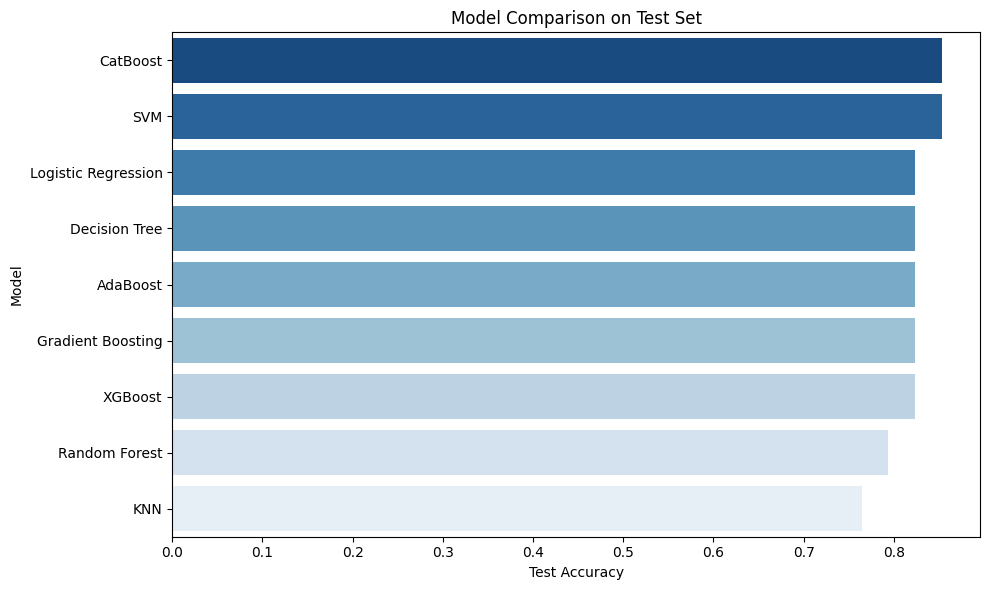

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(x="Test Accuracy", y="Model", data=report_df, hue= "Model", palette="Blues_r")
plt.title("Model Comparison on Test Set")
plt.tight_layout()
plt.show()


In [16]:
best_model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_preprocess', ...), ('cat_preprocess', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
print(f"Best model is {best_model.named_steps['classifier']} with Accuracy (test): {best_score * 100:.2f}%")

Best model is SVC(C=100, gamma='auto', probability=True) with Accuracy (test): 85.29%


## Save the Preprocessor, the Best Model and the Report df

In [18]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

os.makedirs('models', exist_ok= True)

# preprocessor_path = f'models/preprocessor_{timestamp}.pkl'
# joblib.dump(preprocessor, preprocessor_path)

best_model_path = f'models/best_model_{timestamp}.pkl'
joblib.dump(best_model, best_model_path)

report_path = f'models/report_{timestamp}.csv'
report_df.to_csv(report_path, index= False)

## Confusion Matrix

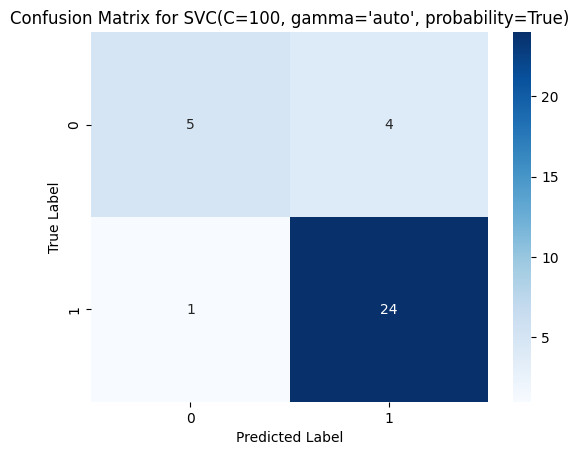

In [22]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot= True, cmap='Blues')
plt.title(f"Confusion Matrix for {best_model.named_steps['classifier']}")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## ROC Curve

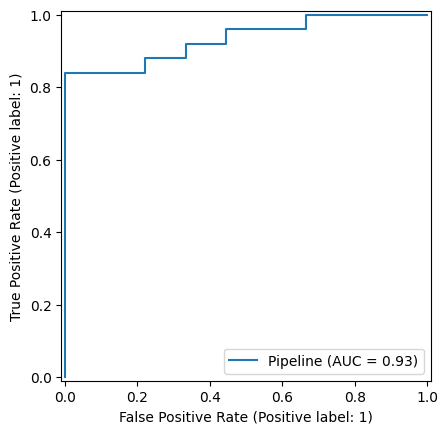

In [20]:
if hasattr(best_model, 'predict_proba') and len(np.unique(y)) == 2:
    RocCurveDisplay.from_estimator(best_model, X_test, y_test)
    plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.86      0.96      0.91        25

    accuracy                           0.85        34
   macro avg       0.85      0.76      0.79        34
weighted avg       0.85      0.85      0.84        34

